In [146]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

In [147]:
# GeoPandas comes with some data that we can quickly load in
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [148]:
world.crs

{'init': 'epsg:4326'}

In [149]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


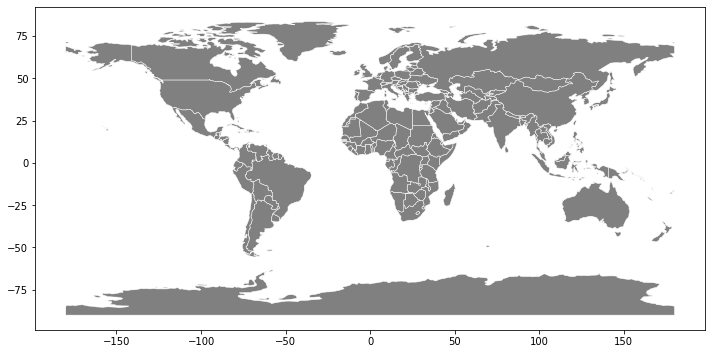

In [150]:
 # You'll usually want to customize how your map looks
world.plot(color='grey', linewidth=0.5, edgecolor='white', figsize=(12,10))

In [151]:
# We'll need to load in some local data
import os
data_pth = "../Data/" 

In [152]:
# GeoPandas comes with city data, but its just the capital cities, so I'll load in my own
cities = gpd.read_file(os.path.join(data_pth, "ne_10m_populated_places.shp"))

In [153]:
cities.crs

{'init': 'epsg:4326'}

In [154]:
cities.head()

,NAME,ADM0NAME,POP,geometry
0,Colonia del Sacramento,Uruguay,21714,POINT (-57.84000 -34.48000)
1,Trinidad,Uruguay,21093,POINT (-56.90100 -33.54400)
2,Fray Bentos,Uruguay,23279,POINT (-58.30400 -33.13900)
3,Canelones,Uruguay,19698,POINT (-56.28400 -34.53800)
4,Florida,Uruguay,32234,POINT (-56.21500 -34.09900)


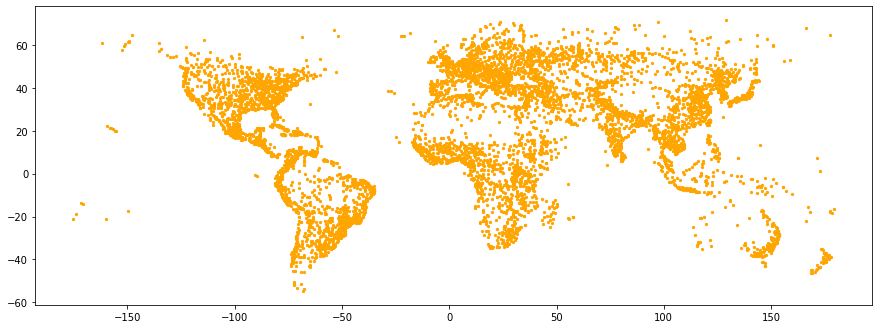

In [155]:
# And plot to view the spatial component
cities.plot(figsize=(15,10), color='orange', markersize=5)

In [156]:
world.crs == cities.crs

True

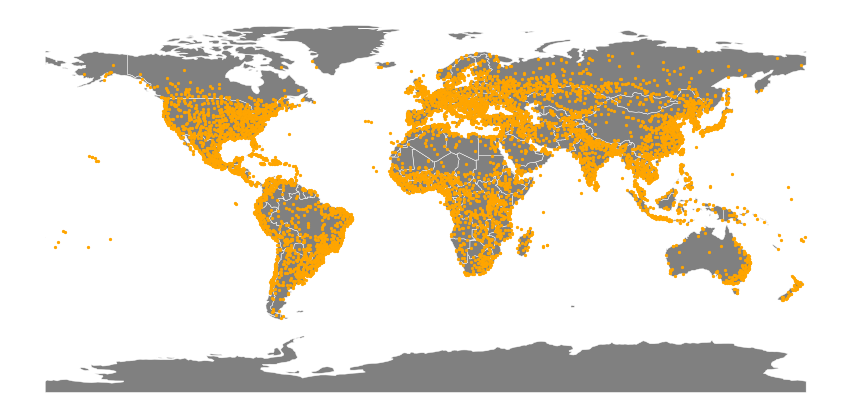

In [157]:
base = world.plot(color='grey', linewidth=0.5, edgecolor='white', figsize=(15,10))
cities.plot(ax=base, color='orange', markersize=5)
base.set_axis_off() 

In [158]:
# Load in Eclipse data
eclipses = gpd.read_file(os.path.join(data_pth, "Eclipses.shp"))

In [159]:
# Check the coorindate reference system
eclipses.crs

{'init': 'epsg:4326'}

In [160]:
eclipses.head()

,Year,geometry
0,2017,"POLYGON Z ((-171.577 39.738 0.000, -171.740 39..."
1,2019,"POLYGON Z ((-160.398 -37.648 0.000, -160.654 -..."
2,2020,"POLYGON Z ((-132.816 -7.774 0.000, -132.743 -7..."
3,2021,"POLYGON Z ((-51.183 -53.087 0.000, -48.952 -51..."
4,2023,"POLYGON Z ((180.000 3.217 0.000, 180.000 3.123..."


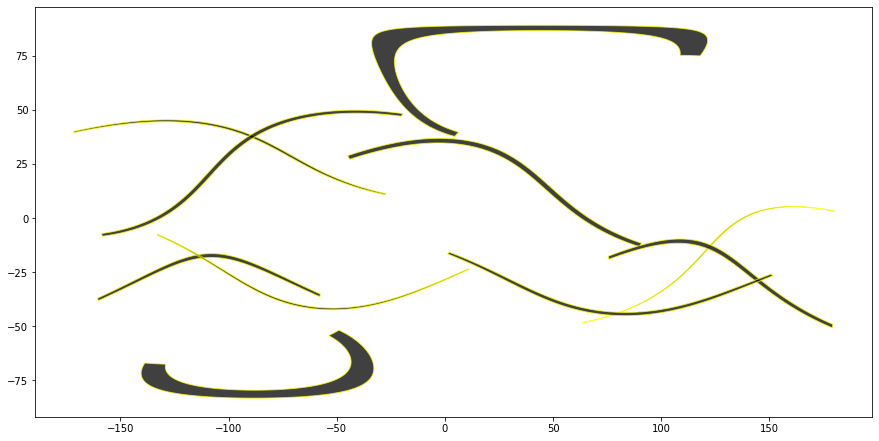

In [161]:
# And let's plot with a customized style
eclipses.plot(figsize=(15,10), color='black', edgecolor='yellow', alpha=0.75)

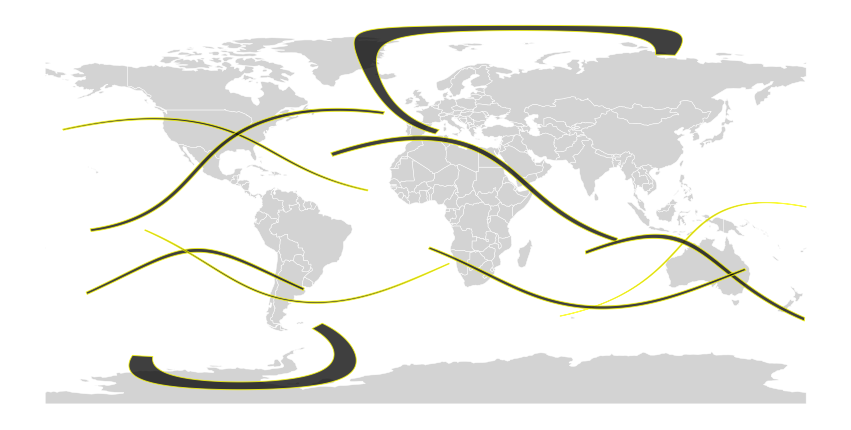

In [162]:
# Let's plot the eclipses on top of our world data
base = world.plot(color='lightgrey', linewidth=0.5, edgecolor='white', figsize=(15,10))
eclipses.plot(ax=base, color='black', edgecolor='yellow', alpha=0.75)
base.set_axis_off()
plt.savefig('eclipsemap.png', bbox_inches=0, orientation='landscape', pad_inches=0.1)

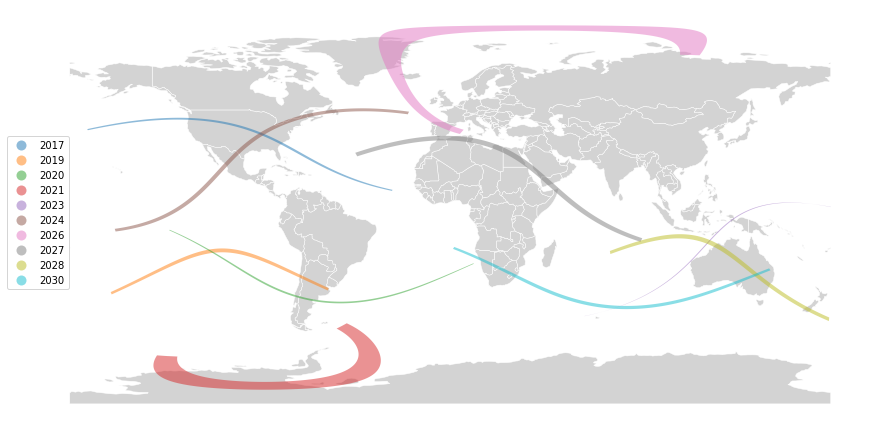

In [163]:
# But how do we know which is which?
base = world.plot(color='lightgrey', linewidth=0.5, edgecolor='white', figsize=(15,10))

# We can add a catetorical value and set the column to Year. We can also add a legend.
eclipses.plot(ax=base, cmap='tab10', alpha=0.5, categorical = True, column = "Year", legend=True)
base.set_axis_off()
base.get_legend().set_bbox_to_anchor((.05,.7))

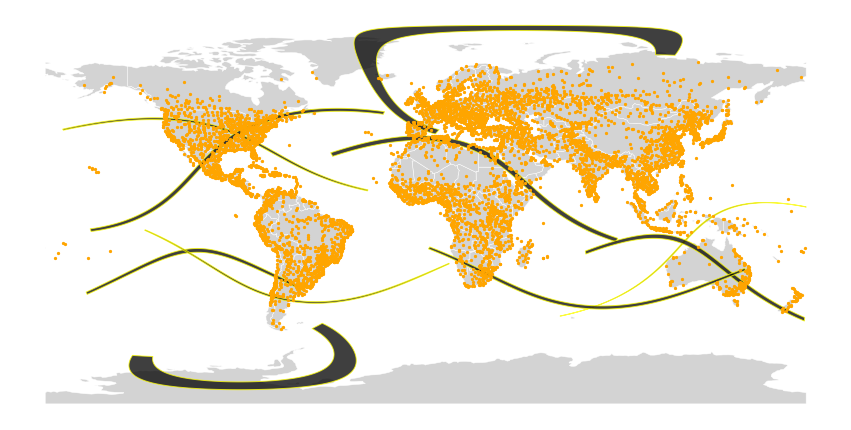

In [164]:
# Now we'll plot our basemap, our eclipse paths, and our cities
base = world.plot(color='lightgrey', linewidth=0.5, edgecolor='white', figsize=(15,10))
eclipses.plot(ax=base, color='black', edgecolor='yellow', alpha=0.75)
cities.plot(ax=base, color='orange', markersize=5)
base.set_axis_off()
#plt.savefig('eclipsemap.png')

In [165]:
# Start by getting all the cities that intersect any eclipse, a spatial join using the geom column
all_e_cities = gpd.sjoin(cities, eclipses, how='inner', op='intersects')

In [166]:
import tensorflow as tf

In [167]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [168]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [169]:
content_path = 'eclipsemap.png'
#tf.keras.utils.get_file('Heaton.jpg', 'http://christyheaton.github.io/images/Heaton.jpg')

# https://commons.wikimedia.org/wiki/File:Vassily_Kandinsky,_1913_-_Composition_7.jpg
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

In [170]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [171]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

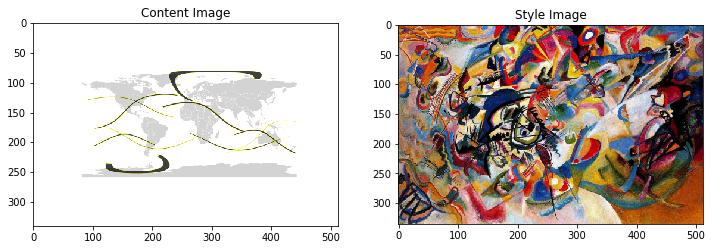

In [172]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

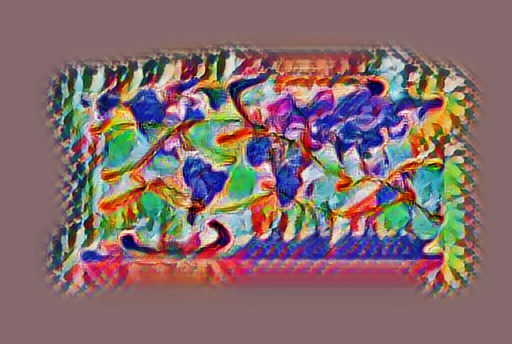

In [173]:
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)